# Test Field

In [101]:
# utility 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper


Device: cuda


True


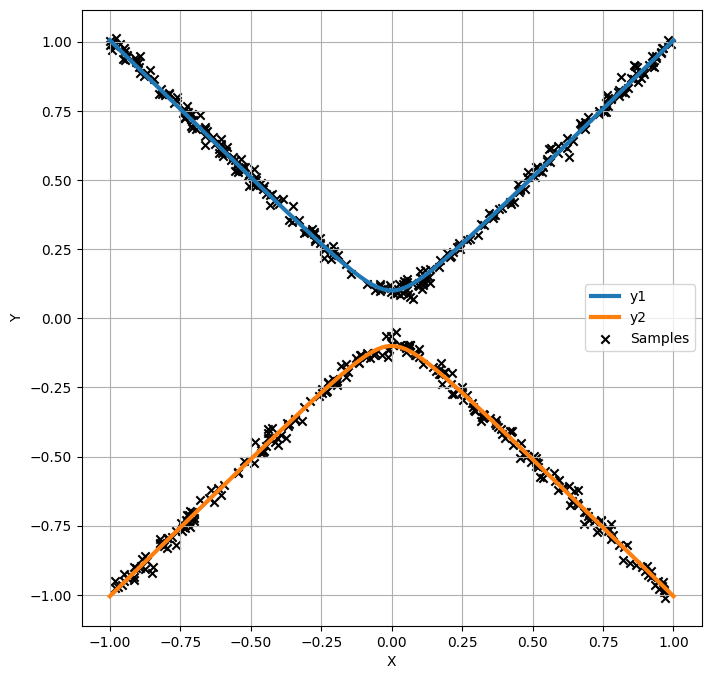

In [102]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2

y_multi = y_hyperbola

# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
# plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()



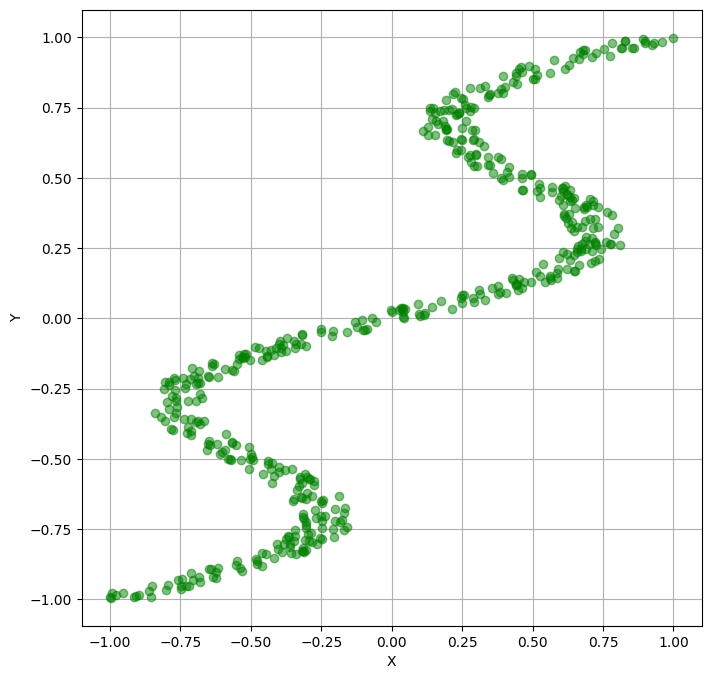

In [65]:
# Another example: inverse sine wave,
# a classic multi-modal output dataset introduced by (Bishop 1994) in Mixture density networks
# generate data
n = 500
d = 1
t = 1
y = np.random.uniform(-1, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
x = y + 0.5 * np.sin(2 * np.pi * y) + noise

# Scale y_train to be in the range of -1 to 1
x = 2 * (x - x.min()) / (x.max() - x.min()) - 1


# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, 'go', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


In [98]:
# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Discriminator modified to output raw logits instead of sigmoid
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            # Removed sigmoid to get raw logits
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)
    
def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss with gradient penalty"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)

    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)

    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))

    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))
    
    

def compute_discriminator_loss_with_grad_penal(discriminator, real_samples, fake_samples, condition, lambda_gp=1.0):
    """Compute discriminator loss with gradient penalty"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)
    
    # Compute log probabilities
    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)  # Add small epsilon to prevent log(0)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)
    
    # Average over batch
    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))
    
    # Gradient penalty
    interpolates = real_samples
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates, condition)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    
    loss += gradient_penalty
    
    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(torch.sigmoid(d_fake) + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            x_input = batch_x
            y_target = batch_y
            
            # Step 1: Update discriminator
            for _ in range(30):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size)
                
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, y_target, fake_y_target.detach(), x_input
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(x_input.size(0), generator.latent_size)
            fake_y_target = generator(z, x_input)
            g_loss = compute_generator_loss(discriminator, fake_y_target, x_input)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 0
hidden_size = 64
output_size = 1
condition_size = 1
num_epochs = 100
batch_size = 32
learning_rate_d = 0.0002
learning_rate_g = 0.00005

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/100], Discriminator Loss: 0.7534, Generator Loss: 1.2820
Epoch [2/100], Discriminator Loss: 0.2527, Generator Loss: 2.6203
Epoch [3/100], Discriminator Loss: 0.2587, Generator Loss: 3.4465
Epoch [4/100], Discriminator Loss: 0.2558, Generator Loss: 3.6029
Epoch [5/100], Discriminator Loss: 0.1833, Generator Loss: 4.0832
Epoch [6/100], Discriminator Loss: 0.0713, Generator Loss: 4.4747
Epoch [7/100], Discriminator Loss: 0.0940, Generator Loss: 4.4758
Epoch [8/100], Discriminator Loss: 0.1361, Generator Loss: 3.6682
Epoch [9/100], Discriminator Loss: 0.1890, Generator Loss: 3.8012
Epoch [10/100], Discriminator Loss: 0.1006, Generator Loss: 3.8308
Epoch [11/100], Discriminator Loss: 0.1367, Generator Loss: 4.1901
Epoch [12/100], Discriminator Loss: 0.0430, Generator Loss: 4.6984
Epoch [13/100], Discriminator Loss: 0.0264, Generator Loss: 4.6178
Epoch [14/100], Discriminator Loss: 0.1211, Generator Loss: 4.7820
Epoch [15/100], Discriminator Loss: 0.1568, Generator Loss: 3.9031
Epoc

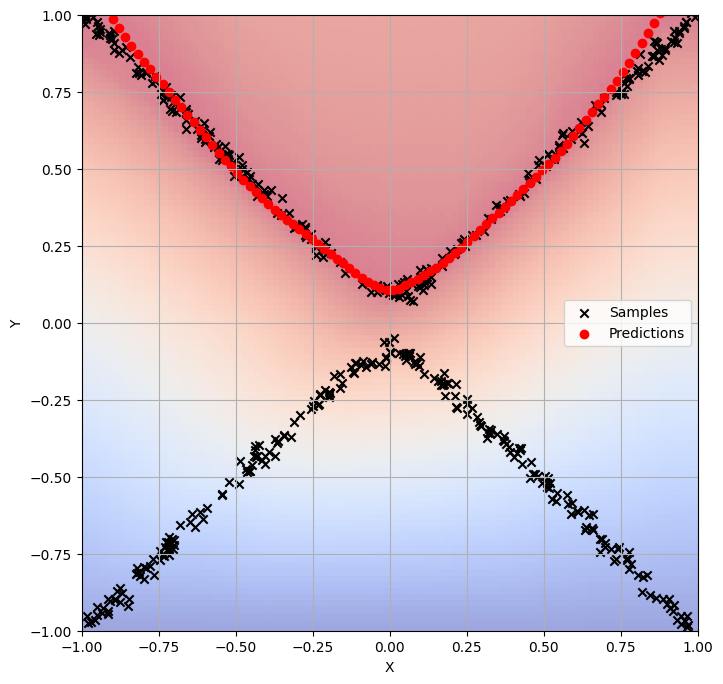

In [103]:
# Visualize the discriminator output heatmap and the predictions
# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions = generator(z, query_points_tensor).detach().numpy()

# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Compute discriminator output for each grid point
discriminator_outputs = []
for point in grid_points:
    x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
    y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
    output = discriminator(y_plot, x_plot).detach()
    # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
    discriminator_outputs.append(output.item())

# Reshape the outputs to match the grid
discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
# Normalize every column of the heatmap
discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

# As energy, take minus of the discriminator output
discriminator_outputs = -discriminator_outputs

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)
# cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)


# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val,  linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=1)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: 0.5651
Epoch [2/100], Generator Loss: 0.5623
Epoch [3/100], Generator Loss: 0.5380
Epoch [4/100], Generator Loss: 0.5335
Epoch [5/100], Generator Loss: 0.5225
Epoch [6/100], Generator Loss: 0.5038
Epoch [7/100], Generator Loss: 0.5023
Epoch [8/100], Generator Loss: 0.4827
Epoch [9/100], Generator Loss: 0.4703
Epoch [10/100], Generator Loss: 0.4699
Epoch [11/100], Generator Loss: 0.4465
Epoch [12/100], Generator Loss: 0.4232
Epoch [13/100], Generator Loss: 0.4287
Epoch [14/100], Generator Loss: 0.4068
Epoch [15/100], Generator Loss: 0.4061
Epoch [16/100], Generator Loss: 0.3873
Epoch [17/100], Generator Loss: 0.3542
Epoch [18/100], Generator Loss: 0.3486
Epoch [19/100], Generator Loss: 0.3311
Epoch [20/100], Generator Loss: 0.3321
Epoch [21/100], Generator Loss: 0.3066
Epoch [22/100], Generator Loss: 0.3014
Epoch [23/100], Generator Loss: 0.2944
Epoch [24/100], Generator Loss: 0.2927
Epoch [25/100], Generator Loss: 0.2847
Epoch [26/100], Generator Loss: 0.

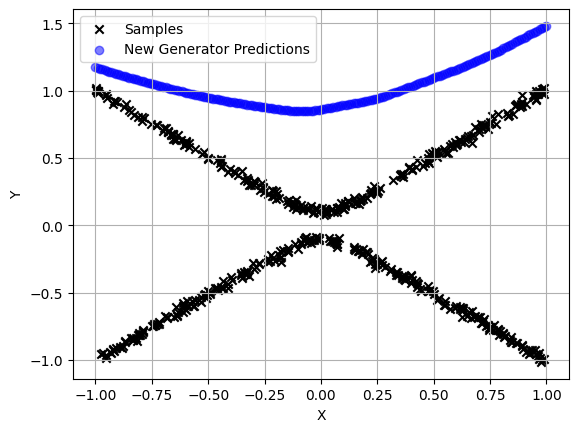

In [90]:
# Fix the discriminator and train a new generator
# Fix the discriminator parameters
for param in discriminator.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x
        y_target = batch_y
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_generator.latent_size)
        
        # Generate fake samples
        fake_y_target = new_generator(z, x_input)
        
        # Compute generator loss
        g_loss = compute_generator_loss(discriminator, fake_y_target, x_input)
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")
    
    
# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions_new = new_generator(z, query_points_tensor).detach().numpy()

# # Plot the function, samples, and predictions from new_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

In [77]:
# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Training loop
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
            
            # Compute loss
            loss = criterion(model, x_input, y_target, counter_samples)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
# Hyperparameters
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 64
learning_rate = 0.001

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Initialize model, optimizer, scheduler
energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train the model
train(energy_model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Loss: 4.1264, LR: 0.001000
Epoch [2/100], Loss: 4.0397, LR: 0.001000
Epoch [3/100], Loss: 3.9433, LR: 0.001000
Epoch [4/100], Loss: 3.8518, LR: 0.001000
Epoch [5/100], Loss: 3.7787, LR: 0.001000
Epoch [6/100], Loss: 3.7225, LR: 0.001000
Epoch [7/100], Loss: 3.6843, LR: 0.001000
Epoch [8/100], Loss: 3.6538, LR: 0.001000
Epoch [9/100], Loss: 3.6166, LR: 0.001000
Epoch [10/100], Loss: 3.5869, LR: 0.001000
Epoch [11/100], Loss: 3.5603, LR: 0.001000
Epoch [12/100], Loss: 3.5351, LR: 0.001000
Epoch [13/100], Loss: 3.5128, LR: 0.001000
Epoch [14/100], Loss: 3.4862, LR: 0.001000
Epoch [15/100], Loss: 3.4801, LR: 0.001000
Epoch [16/100], Loss: 3.4536, LR: 0.001000
Epoch [17/100], Loss: 3.4319, LR: 0.001000
Epoch [18/100], Loss: 3.4245, LR: 0.001000
Epoch [19/100], Loss: 3.4008, LR: 0.001000
Epoch [20/100], Loss: 3.3861, LR: 0.000500
Epoch [21/100], Loss: 3.3663, LR: 0.000500
Epoch [22/100], Loss: 3.3647, LR: 0.000500
Epoch [23/100], Loss: 3.3664, LR: 0.000500
Epoch [24/100], Loss

In [78]:
# Derivative-free optimizer for inference
def ebm_infer(energy_model, target_x_input, y_min, y_max, samples=16384, iterations=4, sigma_init=0.33, scale=0.5):
    """
    Find y_target that minimize energy for a given target x_input.

    Args:
        energy_model: Trained energy-based model.
        target_x_input: Target x_input (Cartesian coordinates), shape: (1, input_dim).
        y_min: Minimum values for joint y_target (tensor).
        y_max: Maximum values for joint y_target (tensor).
        samples: Number of random samples for initial exploration.
        iterations: Number of optimization iterations.
        sigma_init: Initial noise level for exploration.
        scale: Scaling factor for noise reduction.

    Returns:
        Optimal joint y_target minimizing the energy.
    """
    device = target_x_input.device
    target_x_input = target_x_input.repeat(samples, 1)  # Repeat for batch inference
    sigma = sigma_init

    # Initialize random joint y_target samples
    y_target = torch.rand((samples, y_min.size(-1)), device=device) * (y_max - y_min) + y_min

    for _ in range(iterations):
        # Compute energies for current samples
        # If energy_model is type EnergyModel, you can use energy_model(target_x_input, y_target)
        # elif energy_model is typr Discriminator, you can use -energy_model(y_target, target_x_input)
        if isinstance(energy_model, EnergyModel):
            energies = energy_model(target_x_input, y_target)
        elif isinstance(energy_model, Discriminator):
            energies = -energy_model(y_target, target_x_input)
        else:
            raise ValueError("Invalid energy model type.")

        # Softmax over negative energies for sampling probabilities
        probabilities = torch.softmax(-energies, dim=0)

        # Resample based on probabilities
        indices = torch.multinomial(probabilities, num_samples=samples, replacement=True)
        y_target = y_target[indices]

        # Add noise for exploration
        y_target += torch.randn_like(y_target) * sigma
        y_target = torch.clamp(y_target, y_min, y_max)  # Clamp to valid joint y_target bounds

        # Reduce noise scale
        sigma *= scale

    # Return the y_target corresponding to the minimum energy
    best_idx = torch.argmin(energies)
    return y_target[best_idx].unsqueeze(0)  # Shape: (1, action_dim)


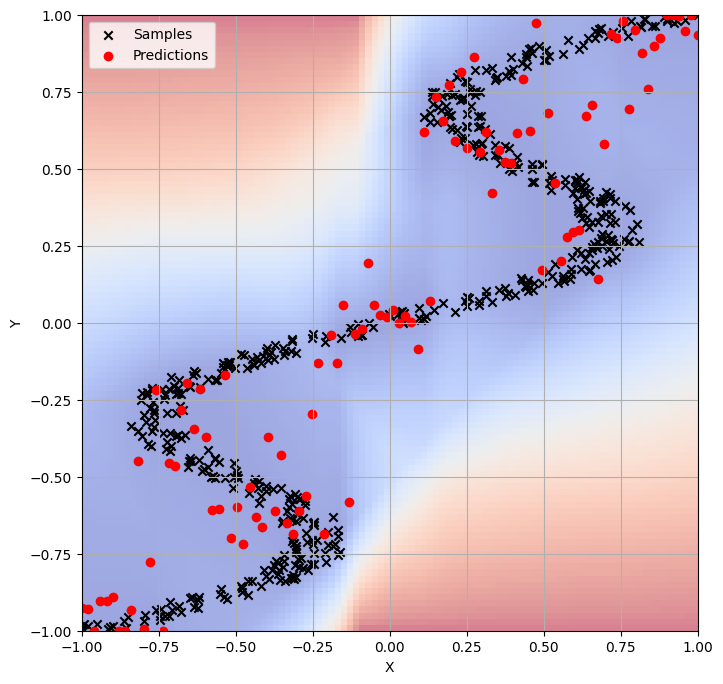

In [79]:

# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)

predictions = []
for point in query_points:
    query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
    prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
    predictions.append(prediction.item())


# Visualize the energy model output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=1)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
plt.show()




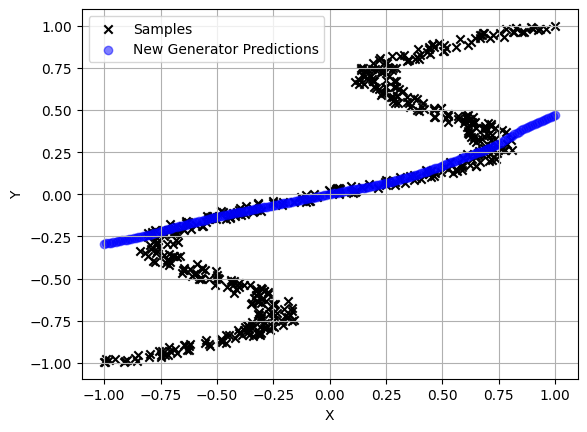

In [73]:
# Fixed the energy model and train a new generator
# Fix the energy model parameters
for param in energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x.to(device)
        y_target = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_generator.latent_size).to(device)
        
        # Generate fake samples using the generator and x_input
        fake_y_target = new_generator(z, x_input)
        
        # Compute generator loss
        g_loss = energy_model(x_input, fake_y_target).mean()
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    # print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")

# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_new = new_generator(z, query_points_tensor).detach().cpu().numpy()

# # Plot the function, samples, and predictions from new_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()


In [74]:
# Hyperparameters
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
hidden_size = 64


num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005

# Training loop combining energy model with GAN
def train_ebgan(model, generator, dataloader, criterion, optimizer_e, optimizer_g, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Append the fake samples to the counter samples
                counter_samples.append(fake_y_target)
                
                # Compute loss
                loss = criterion(model, x_input, y_target, counter_samples)
                
                # Backpropagation
                optimizer_e.zero_grad()
                loss.backward()
                optimizer_e.step()
                
                epoch_loss += loss.item()
                
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator(z, x_input)
            g_loss = energy_model(x_input, fake_y_target).mean()
            
            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader) /repeat_energy_updates
        print(f"Epoch [{epoch+1}/{num_epochs}], Energy Loss: {avg_loss:.4f}, Generator Loss: {g_loss.item():.4f}")
       

# Initialize a new generator
ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
ebgan_energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_generator.parameters(), lr=learning_rate_g)

# Train the ebgan model
train_ebgan(ebgan_energy_model, ebgan_generator, dataloader, info_nce_loss, optimizer_ebgan_e, optimizer_ebgan_g, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Energy Loss: 3.4919, Generator Loss: -1.3491
Epoch [2/100], Energy Loss: 3.4128, Generator Loss: -1.7591
Epoch [3/100], Energy Loss: 3.3185, Generator Loss: -1.3979
Epoch [4/100], Energy Loss: 3.2099, Generator Loss: -2.6036
Epoch [5/100], Energy Loss: 3.1350, Generator Loss: -1.7857
Epoch [6/100], Energy Loss: 3.0982, Generator Loss: -1.4591
Epoch [7/100], Energy Loss: 3.0623, Generator Loss: -0.4302
Epoch [8/100], Energy Loss: 3.0326, Generator Loss: -0.1920
Epoch [9/100], Energy Loss: 3.0181, Generator Loss: -1.4592
Epoch [10/100], Energy Loss: 3.0034, Generator Loss: -2.3622
Epoch [11/100], Energy Loss: 2.9735, Generator Loss: -1.1902
Epoch [12/100], Energy Loss: 2.9676, Generator Loss: -2.1050
Epoch [13/100], Energy Loss: 2.9486, Generator Loss: -1.0525
Epoch [14/100], Energy Loss: 2.9360, Generator Loss: -1.3362
Epoch [15/100], Energy Loss: 2.9336, Generator Loss: -2.4606
Epoch [16/100], Energy Loss: 2.9181, Generator Loss: -1.8002
Epoch [17/100], Energy Loss: 2.89

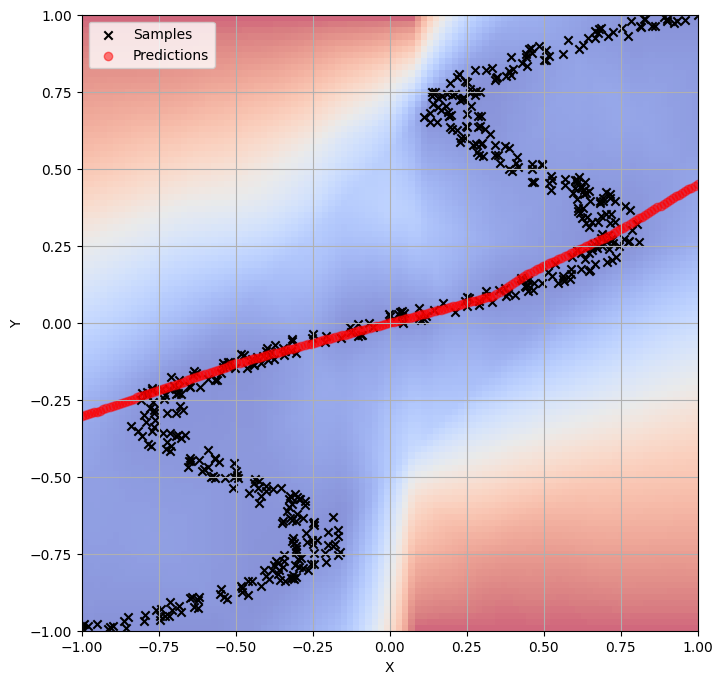

In [80]:
# Random sample the query points and get the predictions using ebgan_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_ebgan = ebgan_generator(z, query_points_tensor).detach().cpu().numpy()

# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = ebgan_energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions_ebgan, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_ebgan.png', dpi=300)
plt.show()

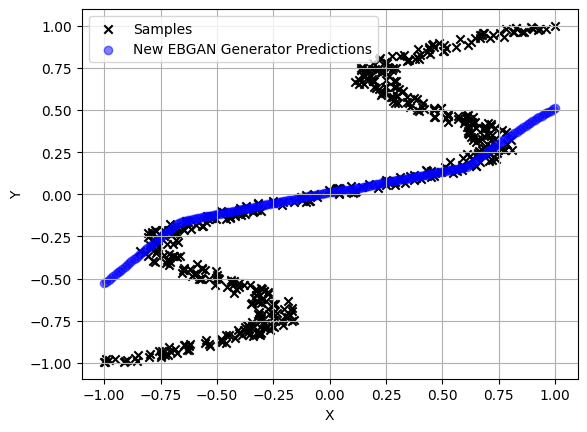

In [81]:
# Train new generator with with fixed ebgan_energy_model
# Fix the ebgan_energy_model parameters
for param in ebgan_energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Randomize the weights of the new generator
for param in new_ebgan_generator.parameters():
    nn.init.normal_(param, mean=0, std=0.2)
    

# Optimizer for the new generator
optimizer_new_ebgan_g = optim.Adam(new_ebgan_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_ebgan_g = 100
for epoch in range(num_epochs_new_ebgan_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x.to(device)
        y_target = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_ebgan_generator.latent_size).to(device)
        
        # Generate fake samples using the generator and x_input
        fake_y_target = new_ebgan_generator(z, x_input)
        
        # Compute generator loss
        g_loss = ebgan_energy_model(x_input, fake_y_target).mean()
        
        # Update generator
        optimizer_new_ebgan_g.zero_grad()
        g_loss.backward()
        optimizer_new_ebgan_g.step()
    
    # print(f"Epoch [{epoch+1}/{num_epochs_new_ebgan_g}], Generator Loss: {g_loss.item():.4f}")

# Random sample the query points and get the predictions using new_ebgan_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_new_ebgan = new_ebgan_generator(z, query_points_tensor).detach().cpu().numpy()

# # Plot the function, samples, and predictions from new_ebgan_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new_ebgan, marker='o', color='blue', label='New EBGAN Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

---